<a href="https://colab.research.google.com/github/shadab4150/X_Ray_Covid_19_pnemonia_detection/blob/master/chest_xray_segmentation_lungs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as immg
import gc
import warnings
warnings.filterwarnings("ignore")

In [0]:
!unzip '/content/drive/My Drive/chest_mask.zip' -d '/content/chest/'

* copied to shadabsayeedxxx@gmail.com drive

In [0]:
path = Path('/content/chest')

In [7]:
path.ls()

[PosixPath('/content/chest/masks'),
 PosixPath('/content/chest/train'),
 PosixPath('/content/chest/.ipynb_checkpoints')]

# Data

In [0]:
fnames = get_image_files(path/'train')
fnamesMask = get_image_files(path/'masks')

In [0]:
path_lbl = path/'masks'
path_img = path/'train'
get_y_fn = lambda x: path_lbl/f'{x.stem}_mask{x.suffix}'
codes = np.array([0,1])

## Function to show chest X_ray with Mask

In [0]:
def show_chest(f,s):  # f = file_name, s = size 
  img_a = immg.imread(f)
  img_a_mask = immg.imread(get_y_fn(f))
  plt.figure(1,figsize=(s,s))
  plt.imshow(img_a,alpha=0.3)
  plt.imshow(img_a_mask,alpha=0.3)
  plt.axis('off')
  plt.show()

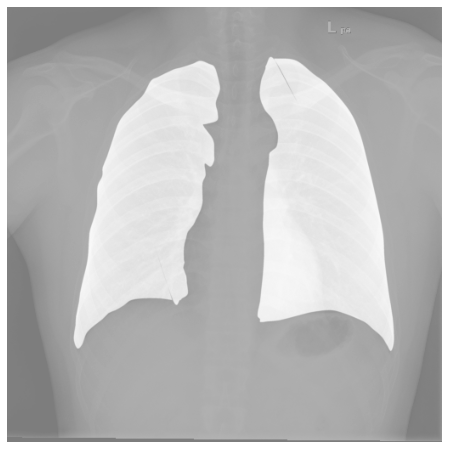

In [52]:
show_chest(fnames[0],8)

In [53]:
gc.collect()

2282

In [0]:
data = (SegmentationItemList.from_folder(path=path/'train')
        .split_by_rand_pct(0.2)
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), size=128, tfm_y=True)
        .databunch(bs=32)
        .normalize(imagenet_stats))

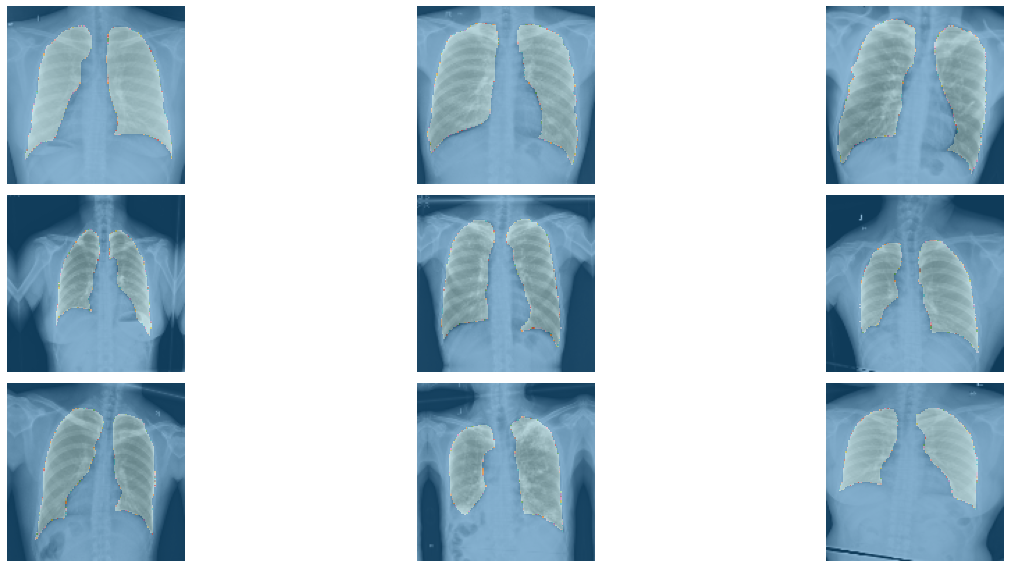

In [55]:
data.show_batch(rows=3,figsize=(20,8));

In [56]:
len(data.train_ds),len(data.valid_ds)

(453, 113)

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = -1

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet18, metrics=[acc_camvid],wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


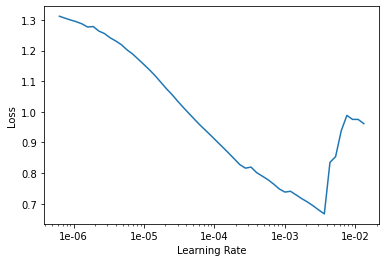

In [61]:
learn.lr_find()
learn.recorder.plot()

In [64]:
gc.collect()

28

In [65]:
learn.fit_one_cycle(10, slice(1e-3) )

epoch,train_loss,valid_loss,acc_camvid,time
0,0.536918,1.180405,0.353042,00:09
1,0.377497,0.140910,0.719305,00:09
2,0.264062,0.092520,0.731109,00:09
3,0.203766,0.085435,0.741596,00:08
4,0.167054,0.080435,0.737752,00:08
5,0.142368,0.079413,0.740819,00:09
6,0.125980,0.077223,0.738180,00:08
7,0.114001,0.077629,0.741103,00:08
8,0.105367,0.076832,0.738825,00:08
9,0.099190,0.076585,0.739387,00:08


In [0]:
learn.export('/content/chestmask.pkl')

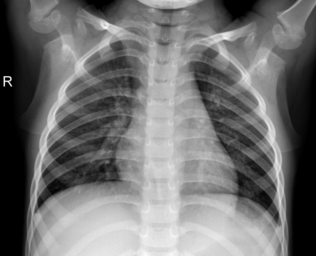

In [66]:
img = open_image('/content/IM-0266-0001.jpeg_I.png');img

In [0]:
mask = learn.predict(img);mask[0]

In [0]:
model = load_learner('/content/','chestmask.pkl')

In [76]:
model.predict(img)[2].size()

torch.Size([2, 128, 128])